# Q2: Zero Noise Extrapolation [4 points + 1 point]






(c) Can you do better than (a) without increasing the total execution time ? [Extra Credit]

## Q2A

(a) Use 8-node QAOA with P=2 example from HW-3 Q2 and show that ZNE can significantly improve expected cost estimate. Use the idetical noise configuration as superconducting hardware described in Q1 and connectivity map to compile your circuit and perform ZNE using folded CX gates (local folding) to modulate noise levels. Make sure the additional "CX" gates are introduced after the mapping and routing pass. Use three noise levels -- (1) No gate folding (2) gate folding only on second layer of QAOA (3) gate folding on both layers of QAOA.  

Offset: -6.0
Ising Hamiltonian:
SparsePauliOp(['IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'ZIIIIIZI', 'IIIZIZII', 'IZIIIZII', 'IIZIZIII', 'ZIIIZIII', 'IIZZIIII', 'ZZIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


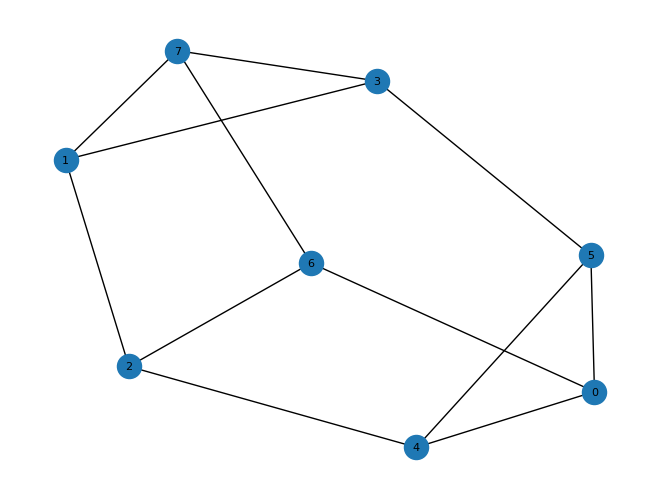

In [ ]:
# Code for Q2
# !pip install qiskit-optimization
import networkx as nx
import time
n = 8
seed = int(time.time() // 1)
graph = nx.random_regular_graph(3, n, seed)
nx.draw(graph, with_labels=True, node_size=300, font_size=8)
from qiskit_optimization.applications import Maxcut
max_cut = Maxcut(graph)
hamiltonian, offset = max_cut.to_quadratic_program().to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(hamiltonian))

In [ ]:
from qiskit_algorithms import NumPyMinimumEigensolver

ground_state_energy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue.real + offset
print(ground_state_energy)

-10.00000000000001


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.transpiler import CouplingMap
import numpy as np
import networkx as nx

# 1. Define hardware connectivity
edges_IBM_27 = [
    (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9),
    (1, 10), (3, 11), (5, 12), (7, 13), (9, 14), (10, 11), (11, 12), (12, 13),
    (13, 14), (10, 15), (11, 16), (12, 17), (13, 18), (14, 19), (15, 16),
    (16, 17), (17, 18), (18, 19), (15, 20), (16, 21), (17, 22), (18, 23),
    (19, 24), (20, 21), (21, 22), (22, 23), (23, 24), (21, 25), (23, 26)
]
# 2. Create QAOA circuit for 8-node linear chain (matches hardware subset)
params = get_initial_point(2)  # Example parameters (beta1, gamma1, beta2, gamma2)

def create_qaoa_circuit():
    qc = QuantumCircuit(8)
    # First layer
    for u, v in graph.edges():
        qc.rzz(2*params[1], u, v)
    for node in graph.nodes():
        qc.rx(2*params[0], node)
    qc.barrier()
    # Second layer
    for u, v in graph.edges():
        qc.rzz(2*params[3], u, v)
    for node in graph.nodes():
        qc.rx(2*params[2], node)
    qc.measure_all()
    return qc

qc = create_qaoa_circuit()

# 3. Transpile for hardware
transpiled_qc = transpile(qc, coupling_map=CouplingMap(edges_IBM_27),basis_gates=["rz", "sx", "x", "cx"],optimization_level=1)

# 4. Gate folding function (updated for physical circuits)
def fold_cx_layers(transpiled_qc, layers_to_fold):
    # Create new circuit with same registers
    new_qc = QuantumCircuit()
    
    # Copy all quantum registers
    for qreg in transpiled_qc.qregs:
        new_qc.add_register(qreg)
        
    # Copy all classical registers
    for creg in transpiled_qc.cregs:
        new_qc.add_register(creg)
    
    layers = []
    current_layer = []
    
    # Split into layers using barriers
    for instr in transpiled_qc.data:
        if instr.operation.name == 'barrier':
            layers.append(current_layer)
            current_layer = []
        else:
            current_layer.append(instr)
    layers.append(current_layer)  # Add final layer
    
    # Rebuild circuit with folded CX gates
    for lidx, layer in enumerate(layers):
        for instr in layer:
            # Append original instruction
            new_qc.append(instr.operation, instr.qubits, instr.clbits)
            
            # Apply CX folding if in target layer
            if lidx in layers_to_fold and instr.operation.name == 'cx':
                # Append two extra CX gates (triple total)
                new_qc.append(instr.operation, instr.qubits)
                new_qc.append(instr.operation, instr.qubits)
                
        # Add barrier unless last layer
        if lidx < len(layers) - 1:
            new_qc.barrier(*transpiled_qc.qubits)
    
    return new_qc

# Create three noise scaling cases
case1 = transpiled_qc  # No folding
case2 = fold_cx_layers(transpiled_qc, [1])  # Fold second layer
case3 = fold_cx_layers(transpiled_qc, [0, 1])  # Fold both layers

# 5. Simulation with noise (using MaxCut expectation)
def maxcut_expectation(counts, graph):
    total = 0
    shots = sum(counts.values())
    for bitstr, count in counts.items():
        cut = 0
        for u, v in graph.edges():
            if bitstr[7-u] != bitstr[7-v]:  # Qiskit uses reverse bit-order
                cut += 1
        total += cut * count
    return total / shots

error_rate = 0.001  # From Q1
noise_model = NoiseModel()
cnot_error = depolarizing_error(error_rate, 2)
noise_model.add_all_qubit_quantum_error(cnot_error, ['cx'])

# Run simulations
sim = AerSimulator(noise_model=noise_model)
results = {}
for case, circuit in zip(['1x', '2x', '3x'], [case1, case2, case3]):
    job = sim.run(circuit)
    counts = job.result().get_counts()
    results[case] = maxcut_expectation(counts, graph)

# 6. ZNE extrapolation
scale_factors = np.array([1, 2, 3])  # Corresponding to 1x, 2x, 3x CX counts
E = np.array([results['1x'], results['2x'], results['3x']])

# Quadratic extrapolation (better for larger noise)
A = np.vstack([scale_factors**2, scale_factors, np.ones(3)]).T
a, b, c = np.linalg.lstsq(A, E, rcond=None)[0]
E_zne = c  # Extrapolate to λ=0

# Ideal expectation (no noise)
ideal_sim = AerSimulator()
ideal_counts = ideal_sim.run(transpiled_qc).result().get_counts()
E_ideal = maxcut_expectation(ideal_counts, graph)

print(f"Simulated Expectations:")
print(f"λ=1 (No folding): {results['1x']:.2f}")
print(f"λ=2 (Fold layer 2): {results['2x']:.2f}")
print(f"λ=3 (Fold both): {results['3x']:.2f}")
print(f"ZNE Extrapolated (λ=0): {E_zne:.2f}")
print(f"Ideal Expectation: {E_ideal:.2f}")

Simulated Expectations:
λ=1 (No folding): 4.40
λ=2 (Fold layer 2): 4.51
λ=3 (Fold both): 4.48
ZNE Extrapolated (λ=0): 4.18
Ideal Expectation: 4.29


## Q2B

(b) You have three options -- (1) use ZNE on fast but noisy IBM machine (2) use slower but more reliable H2 machine without ZNE or (3) Aria IonQ hardware without ZNE, which is the best option? Backup your claim with numerical simulations.    


Processing depth 1...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 1 | Device ibm_montreal | Ratio: 0.788
Processing depth 2...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 2 | Device ibm_montreal | Ratio: 0.852
Processing depth 3...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 3 | Device ibm_montreal | Ratio: 0.888
Processing depth 4...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 4 | Device ibm_montreal | Ratio: 0.896
Processing depth 5...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 5 | Device ibm_montreal | Ratio: 0.899
Processing depth 6...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 6 | Device ibm_montreal | Ratio: 0.899
Processing depth 1...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 1 | Device ionq_aria1 | Ratio: 0.789
Processing depth 2...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 2 | Device ionq_aria1 | Ratio: 0.851
Processing depth 3...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 3 | Device ionq_aria1 | Ratio: 0.882
Processing depth 4...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 4 | Device ionq_aria1 | Ratio: 0.886
Processing depth 5...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 5 | Device ionq_aria1 | Ratio: 0.887
Processing depth 6...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 6 | Device ionq_aria1 | Ratio: 0.882
Processing depth 1...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 1 | Device quantinuum_h2 | Ratio: 0.783
Processing depth 2...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 2 | Device quantinuum_h2 | Ratio: 0.836
Processing depth 3...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 3 | Device quantinuum_h2 | Ratio: 0.852
Processing depth 4...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 4 | Device quantinuum_h2 | Ratio: 0.844
Processing depth 5...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 5 | Device quantinuum_h2 | Ratio: 0.838
Processing depth 6...


/tmp/ipykernel_6309/151980808.py:122: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  max_cut = run_qaoa(p, noise_model)


Depth 6 | Device quantinuum_h2 | Ratio: 0.824


NameError: name 'error_rates' is not defined

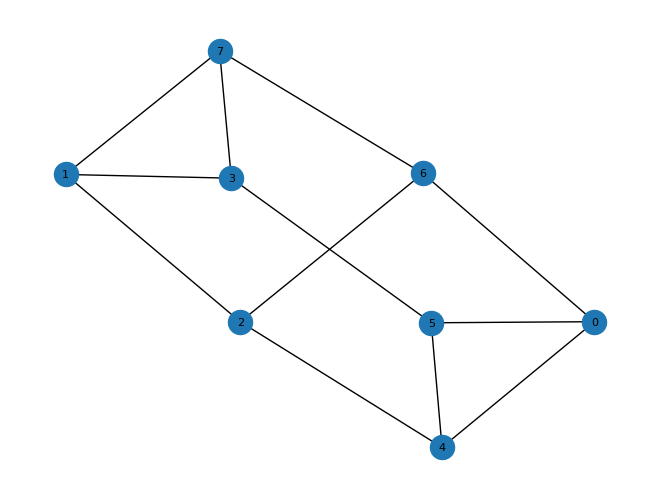

<Figure size 1200x700 with 0 Axes>

In [ ]:

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import QAOAAnsatz
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_optimization.applications import Maxcut


graph = nx.random_regular_graph(3, n, seed)
nx.draw(graph, with_labels=True, node_size=300, font_size=8)
max_cut = Maxcut(graph)
hamiltonian, offset = max_cut.to_quadratic_program().to_ising()
from qiskit_algorithms import NumPyMinimumEigensolver
ground_state_energy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue.real + offset
# 1. Hardware Configuration
DEVICE_CONFIG = {
    "ibm_montreal": {
        "coupling_map": CouplingMap(edges_IBM_27),  # Simplified heavy-hex
        "basis_gates": ["rz", "sx", "x", "cx"],
        "gate_times": {"1q": 20e-9, "2q": 200e-9},
        "readout_latency": 200e-6,
        "T1": 100e-6,   # 100 µs
        "T2": 100e-6,
        "1q_fidelity": 0.999,
        "2q_fidelity": 0.985,
        "readout_fidelity": 0.97
    },
    "ionq_aria1": {
        "coupling_map": CouplingMap(IonQ_25),  # Simplified fully-connected group
        "basis_gates": ["rx", "ry", "rz", "rxx"],
        "gate_times": {"1q": 10e-6, "2q": 100e-6},
        "readout_latency": 1e-3,
        "T1": 1000e-3,  # 1000 ms
        "T2": 1000e-3,
        "1q_fidelity": 0.999,
        "2q_fidelity": 0.99,
        "readout_fidelity": 0.9999
    },
    "quantinuum_h2": {
        "coupling_map": CouplingMap(Quantinuum_H2_32),  # Simplified connected group
        "basis_gates": ["rx", "ry", "rz", "rzz"],
        "gate_times": {"1q": 10e-6, "2q": 150e-6},
        "readout_latency": 1e-3,
        "T1": 500e-3,  # 500 ms
        "T2": 500e-3,
        "1q_fidelity": 0.9997,
        "2q_fidelity": 0.98,
        "readout_fidelity": 0.9999
    }
}
# 2. QAOA Circuit Generation
def create_qaoa_circuit(graph, p=2):
    num_nodes = len(graph.nodes)
    qaoa = QAOAAnsatz(
        cost_operator=hamiltonian,  # Implement graph->Hamiltonian conversion
        reps=p,
        initial_state=QuantumCircuit(num_nodes))
    return qaoa

# 3. Noise Model Creation
def create_noise_model(config, use_zne=False):
    noise_model = NoiseModel()
    
    # 1-qubit errors
    for gate in ["id", "rz", "sx", "x"]:
        error = depolarizing_error(1-config["1q_fidelity"], 1)
        noise_model.add_all_qubit_quantum_error(error, gate)
    
    # 2-qubit errors with ZNE mitigation
    cx_error_rate = (1-config["2q_fidelity"]) * (0.5 if use_zne else 1.0)
    cx_error = depolarizing_error(cx_error_rate, 2)
    noise_model.add_all_qubit_quantum_error(cx_error, ["cx", "rzz", "rxx"])

    # Readout errors
    noise_model.add_readout_error([[config["readout_fidelity"], 1-config["readout_fidelity"]], [1-config["readout_fidelity"], config["readout_fidelity"]]], list(range(num_qubits)))
    return noise_model

def run_qaoa(depth: int, noise_model: NoiseModel | None = None) -> float:
    sampler = Sampler(
        run_options={"shots": 10000, "seed": seed},
        backend_options={"noise_model": noise_model, "device": "CPU"}
    )

    optimizer = COBYLA(maxiter=10000)
    initial_point = get_initial_point(depth)


    qaoa = QAOA(
        sampler=sampler,
        optimizer=optimizer,
        reps=depth,
        initial_point=initial_point
    )

    result = qaoa.compute_minimum_eigenvalue(hamiltonian)

    ground_state_energy = result.eigenvalue.real
    max_cut_value = -(ground_state_energy + offset)

    return max_cut_value

results = {}
# 4. Simulation Function
def run_qaoa_benchmark(graph, device, shots=1000):
    current_ratios = []
    config = DEVICE_CONFIG[device]
    qaoa = create_qaoa_circuit(graph, p=2)
    # Transpile for target device
    transpiled = transpile(qaoa, 
                            basis_gates=config["basis_gates"],
                            coupling_map=config["coupling_map"],
                            optimization_level=3)
    
    # Create noise model
    noise_model = create_noise_model(config, use_zne=(device == "ibm_montreal"))
    
    depths = np.arange(1, 7)
    for p in depths:
        print(f"Processing depth {p}...")
        max_cut = run_qaoa(p, noise_model)
        ratio = max_cut / -ground_state_energy
        current_ratios.append(ratio)
        print(f"Depth {p} | Device {device} | Ratio: {ratio:.3f}")

    results[device]=current_ratios

for device in ["ibm_montreal", "ionq_aria1", "quantinuum_h2"]:
    run_qaoa_benchmark(graph, device)



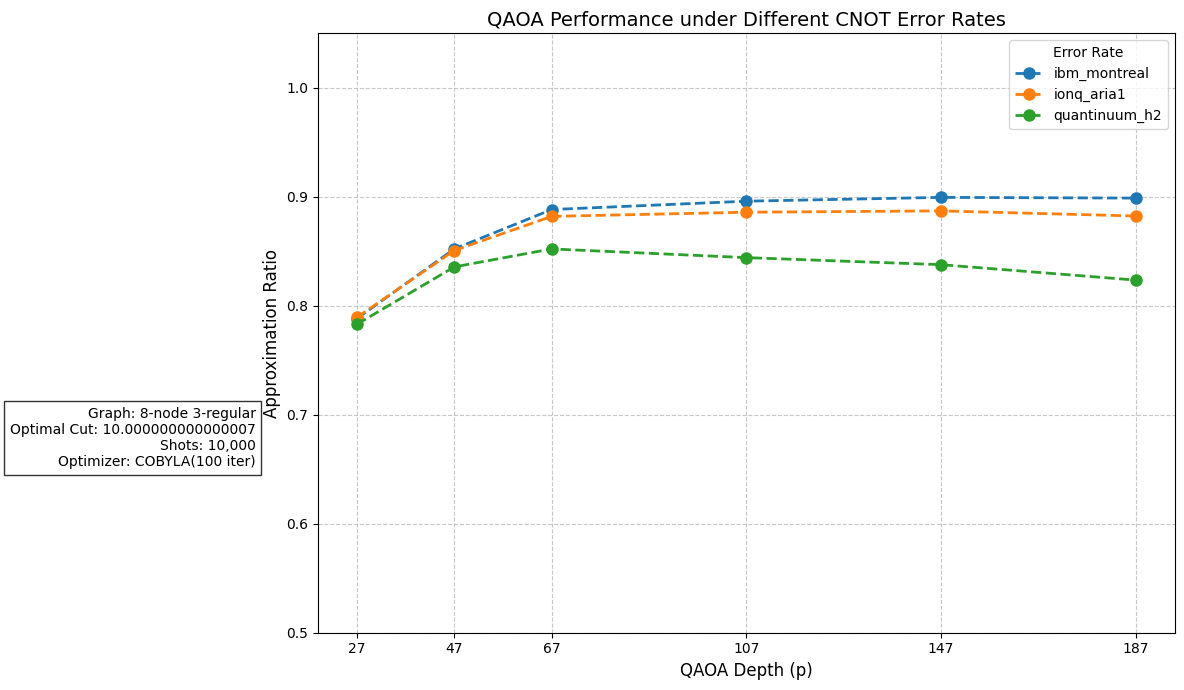

In [ ]:
devices = ["ibm_montreal", "ionq_aria1", "quantinuum_h2"]
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for (device, color) in zip(devices, colors):
    plt.plot(
        depths,
        results[device],
        'o--',
        color=color,
        linewidth=2,
        markersize=8,
        label=device
    )

plt.xlabel("QAOA Depth (p)", fontsize=12)
plt.ylabel("Approximation Ratio", fontsize=12)
plt.title("QAOA Performance under Different CNOT Error Rates", fontsize=14)
plt.xticks(depths)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Error Rate", fontsize=10)
plt.ylim(0.5, 1.05)

plt.text(
    6.2, 0.65,
    f"Graph: {n}-node 3-regular\n"
    f"Optimal Cut: {-ground_state_energy}\n"
    f"Shots: 10,000\n"
    f"Optimizer: COBYLA(100 iter)",
    ha='right', va='bottom',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('qaoa_noise_comparison.png', dpi=300)
plt.show()

After using ZNE, IBM's machine's performence increase a lot, so in general IBM's plan is better.